In [24]:
from main import *
from visualization import *

from scipy.stats import percentileofscore
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 6

red = 1.1 * np.array([186, 44, 102]) / 255
color1 = [0, 0, 0]
blue = hex2rgb('#006DAA')
color3 = [1, 1, 1]
colormap = make_cmap([color1, blue, color3], [0, 0.5, 1])

# Setting paths

In [3]:
atlas_path = '/home/anleg84/Documents/Atlas/MapzebrainOld/'

In [6]:
excluded = np.load('Results/excluded_regions.npy')

In [5]:
atlas = MapzebrainAtlas(atlas_path)

delete = delete_rows_and_columns

# Functions

These functions load the `.swc` files containing coordinates from single-neuron reconstructions, downloadable from https://mapzebrain.org/home.

In [8]:
def read_swc(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    data_lines = [line for line in lines if not line.startswith('#')]
    neuron_data = []
    for line in data_lines:
        parts = line.strip().split()
        if len(parts) == 7:
            neuron_data.append({
                'id': int(parts[0]),
                'type': int(parts[1]),
                'x': float(parts[2]),
                'y': float(parts[3]),
                'z': 359.0 - float(parts[4]),
                'radius': float(parts[5]),
                'parent': int(parts[6])
            })
    return neuron_data

def get_soma_xyz(neuron_data):
    for d in neuron_data:
        if d['parent'] == -1:
            return (d['x'], d['y'], d['z'])

def get_terminals_xyz(neuron_data):
    ids = []
    for d in data:
        ids.append(d['id'])
    ids = np.array(ids)
    is_terminal = np.array([True] * len(ids))
    for d in data:
        parent = d['parent']
        is_terminal[ids == parent] = False
    centroids = []
    for i, v in enumerate(is_terminal):
        if v:
            d = neuron_data[i]
            centroids.append([d['x'], d['y'], d['z']])
    return np.array(centroids)

# These functions serve no purpose.

@njit 
def find_duplicates(somas, terminals):
    duplicates_soma = []
    for i in range(somas.shape[0]):
        duped = False
        for j in range(somas.shape[0]):
            if i != j:
                s1 = somas[i]
                s2 = somas[j]
                if np.array_equal(s1, s2):
                    duped = True
        duplicates_soma.append(duped)
    duplicates_terminals = []
    for i in range(len(terminals)):
        duped = False
        for j in range(len(terminals)):
            if i != j:
                t1 = terminals[i]
                t2 = terminals[j]
                if np.array_equal(t1, t2):
                    duped = True
        duplicates_terminals.append(duped)
    return np.array(duplicates_soma) & np.array(duplicates_terminals)

@njit
def exclude_duplicates(somas, terminals, coords, parents):
    new_somas, new_terminals = [somas[0]], [terminals[0]]
    new_coords, new_parents = [coords[0]], [parents[0]]
    for i in range(1, len(terminals)):
        s, t = somas[i], terminals[i]
        c, p = coords[i], parents[i]
        duplicated = False
        for j in range(len(new_somas)):
            ns, nt = new_somas[j], new_terminals[j]
            e1, e2 = np.array_equal(s, ns), np.array_equal(t, nt)
            if e1 & e2:
                duplicated = True
        if not duplicated:
            new_somas.append(s)
            new_terminals.append(t)
            new_coords.append(c)
            new_parents.append(p)
    return new_somas, new_terminals, new_coords, new_parents

In [9]:
def get_axon_coordinates(neuron_data):
    coords, parents = [], []
    for d in neuron_data:
        coords.append([d['x'], d['y'], d['z']])
        parents.append(d['parent'])
    return np.stack(coords), np.array(parents)

# Loading neurons

In [10]:
folders = identify_folders(atlas.path + 'Neurons/', exclude=['Hidden'])
folder = folders[0]

In [11]:
somas, terminals, coords, parents = [], [], [], []

files = identify_files(folder)
for i in range(len(files)):
    data = read_swc(folder + files[i])
    soma = get_soma_xyz(data)
    if soma is not None:
        somas.append(soma)
        terminals.append(get_terminals_xyz(data))
        c, p = get_axon_coordinates(data)
        coords.append(c)
        parents.append(p)

somas = np.array(somas)

# This part is useless. I had duplicates in an initial download, but managed to fix the problem. Leaving the code here anyway.
# somas, terminals, coords, parents = exclude_duplicates(somas, terminals, coords, parents)

Generating id vectors to map terminals and morphological coordinates to an individual cell id.

In [12]:
ids = []
for i in range(len(terminals)):
    ids += [i] * terminals[i].shape[0]

ids_coords = []
for i in range(len(coords)):
    ids_coords += [i] * coords[i].shape[0]

In [13]:
somas = np.stack(somas)
terminals = np.concatenate(terminals)
coords = np.concatenate(coords)
parents = np.concatenate(parents)
ids_terminals = np.array(ids)
ids_coords = np.array(ids_coords)

In [14]:
N = []
for file in files:
    data = read_swc(folder + file)
    N.append(len(data))

In [15]:
np.save('Results/ids_terminals.npy', ids_terminals)
np.save('Results/terminals.npy', terminals)

# Plotting random neurons

Here we just visualize some of the neurons.

In [16]:
from matplotlib.collections import LineCollection

def plot_neuron_top(ax, neuron_data, color=[0, 1, 0], terminals=True, alpha=0.25, soma_size=30, terminal_size=5):
    soma_xyz = get_soma_xyz(neuron_data)
    terminals_xyz = get_terminals_xyz(neuron_data)
    ids = []
    for d in data:
        ids.append(d['id'])
    ids = np.array(ids)
    positions = []
    for i, d in enumerate(neuron_data[1:]):
        try:
            parent = d['parent']
            d_parent = data[np.where(ids == parent)[0][0]]
            x1, y1 = d_parent['x'], d_parent['y']
            x2, y2 = d['x'], d['y']
            positions.append([(x1, y1), (x2, y2)])
        except:
            pass
    collection = LineCollection(
            positions,
            color=color,
            linewidths=1,
            antialiaseds=(1,),
            alpha=alpha
        )
    ax.add_collection(collection)
    ax.scatter(soma_xyz[0], soma_xyz[1], s=soma_size, color=color, zorder=20, edgecolor='None', alpha=alpha)
    if terminals:
        ax.scatter(terminals_xyz[:, 0], terminals_xyz[:, 1], color=color, alpha=alpha, s=terminal_size, edgecolor='None', zorder=10)

def plot_neuron_side(ax, neuron_data, color=[0, 1, 0], terminals=True, alpha=0.25, soma_size=30, terminal_size=5):
    soma_xyz = get_soma_xyz(neuron_data)
    terminals_xyz = get_terminals_xyz(neuron_data)
    ids = []
    for d in data:
        ids.append(d['id'])
    ids = np.array(ids)
    positions = []
    for i, d in enumerate(neuron_data[1:]):
        try:
            parent = d['parent']
            d_parent = data[np.where(ids == parent)[0][0]]
            y1, z1 = d_parent['y'], d_parent['z']
            y2, z2 = d['y'], d['z']
            positions.append([(y1, z1), (y2, z2)]) 
        except:
            pass
    collection = LineCollection(
        positions,
        color=color,
        linewidths=1,
        antialiaseds=(1,),
        alpha=alpha
    )
    ax.add_collection(collection)
    ax.scatter(soma_xyz[1], soma_xyz[2], s=soma_size, color=color, zorder=20, edgecolor='None', alpha=alpha)
    if terminals:    
        ax.scatter(terminals_xyz[:, 1], terminals_xyz[:, 2], color=color, alpha=alpha, s=terminal_size, edgecolor='None', zorder=10)

In [17]:
N_random = 250
palette = generate_n_colors(10, saturation=65, value=90) * 1000
random_ids = np.where(select_M_from_N(N_random, len(files)))[0]

(0.0, 597.0, 974.0, 0.0)

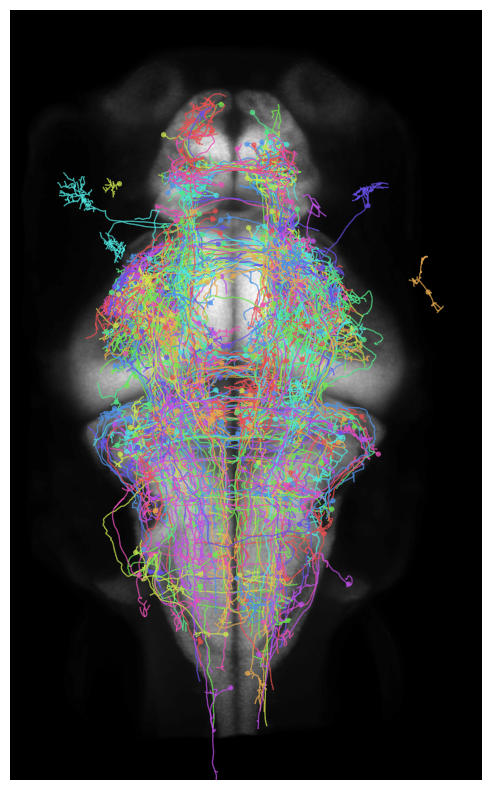

In [18]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(atlas.XYprojection, cmap='gray')
for i, I in enumerate(random_ids):
    data = read_swc(folders[0] + files[I])
    plot_neuron_top(ax, data, terminals=False, color=palette[i], alpha=0.75, soma_size=15)
plt.xlim([0, atlas.XYprojection.shape[1]])
plt.ylim([atlas.XYprojection.shape[0], 0])
plt.axis('off')

(359.0, 0.0)

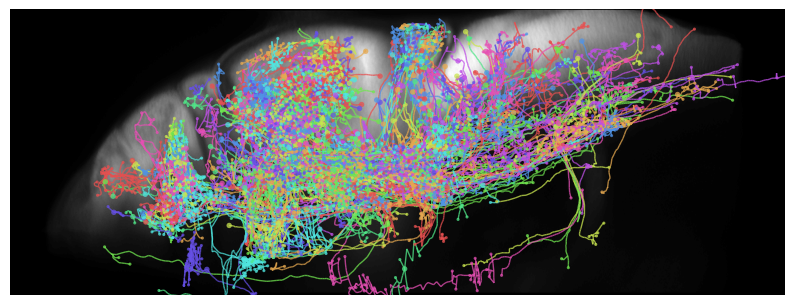

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(atlas.XZprojection, cmap='gray')
for i, I in enumerate(random_ids):
    data = read_swc(folders[0] + files[I])
    plot_neuron_side(ax, data, terminals=True, color=palette[i], alpha=0.75, soma_size=15)
plt.axis('off')
plt.xlim([0, atlas.XZprojection.shape[1]])
plt.ylim([atlas.XZprojection.shape[0], 0])

This is mostly just a validation that we are properly loading and reconstructing those neurons, and handling the data structures.

# Mapping terminals/coordinates in brain regions

In [19]:
from scipy.ndimage import distance_transform_edt

def trim_centroids(centroids):
    centroids[:, 0] = np.clip(centroids[:, 0], 0, 596)
    centroids[:, 1] = np.clip(centroids[:, 1], 0, 973)
    centroids[:, 2] = np.clip(centroids[:, 2], 0, 358)
    return centroids

def map_centroids_expanded(atlas, centroids, boundary_size=20, keep_inside=False):
    centroids = trim_centroids(centroids)
    region_labels = np.zeros((centroids.shape[0], len(atlas.regionNames)))
    for i in tqdm(range(len(atlas.regionNames)), file=sys.stdout):
        mask = atlas.getRegionMask(i)
        dists = distance_transform_edt(1 - (mask / 255))
        if keep_inside:
            mask = (dists <= boundary_size)
        else:
            mask = (dists <= boundary_size) & (dists != 0) # 20 micron boundary without the region mask itself
        region_labels[:, i] = mask[centroids[:, 2], centroids[:, 1], centroids[:, 0]]
    region_labels = region_labels.astype('bool')
    return region_labels

Here, we take the full array of 3D terminal coordinates across all neurons, and we map them in expanded brain atlas regions regions. We use an euclidean distance transform on inverse binary masks to find the peripheral pixels to the ROIs, and then include them into the mask based on a `boundary_size` parameter. This is significantly faster than a morphological dilation operation, for some reason.

In [ ]:
for boundary_size in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]:
    regions_terminals_expanded = map_centroids_expanded(atlas, np.round((terminals)).astype('int'),
                                                          boundary_size=boundary_size, keep_inside=True)

    np.save('Results/regions_terminals_expanded_{}.npy'.format(boundary_size), regions_terminals_expanded)

Mapping terminals in normal-sized regions.

In [ ]:
regions_coords = atlas.mapCentroids(np.round((coords)).astype('int'))
regions_somas = atlas.mapCentroids(np.round((somas)).astype('int'))
regions_terminals = atlas.mapCentroids(np.round((terminals)).astype('int'))

np.save('Results/regions_somas.npy', regions_somas)
np.save('Results/regions_terminals.npy', regions_terminals)
np.save('Results/regions_coords.npy', regions_coords)

# Plotting terminal density

Now we load the terminals and visualize their spatial density in brain atlas.

In [20]:
regions_terminals = np.load('Results/regions_terminals.npy')
regions_terminals_expanded = np.load('Results/regions_terminals_expanded_30.npy')

Symmetrizing the terminal coordinates for visualization purposes.

In [21]:
T1 = np.copy(terminals)
T2 = np.copy(terminals)
T2[:, 0] = -1 *  (T2[:, 0] - 284) + 284
T = np.concatenate([T1, T2])

Computing spatial density and plotting.

In [25]:
density = compute_density_atlas(T, sigma=10)

In [26]:
order = np.argsort(density)

(0.0, 597.0, 974.0, 0.0)

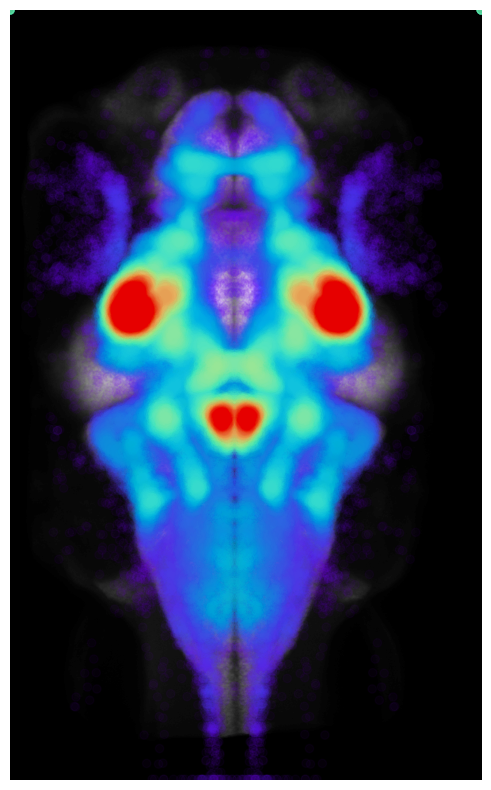

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(atlas.XYprojection, cmap='gray')
plt.scatter(T[order, 0], T[order, 1], alpha=0.04, c=density[order], cmap='rainbow', vmin=0, vmax=0.05)
plt.xlim([0, atlas.XYprojection.shape[1]])
plt.ylim([atlas.XYprojection.shape[0], 0])
plt.axis('off')

(359.0, 0.0)

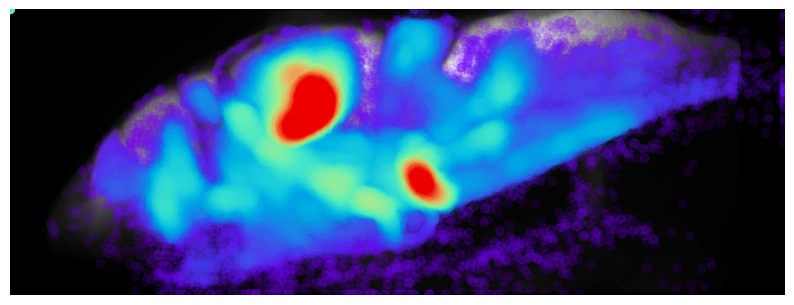

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(atlas.XZprojection, cmap='gray')
plt.scatter(T[order, 1], T[order, 2], alpha=0.05, c=density[order], cmap='rainbow', vmin=0, vmax=0.05)
plt.axis('off')
plt.xlim([0, atlas.XZprojection.shape[1]])
plt.ylim([atlas.XZprojection.shape[0], 0])

density = atlas.generate_centroid_density(np.round(T).astype('int'))
filtered = gaussian_filter(density, 2)
save_stack('Results/supp_terminals_density.tif', filtered)

# Evaluating which terminals are included in brain region masks

In [29]:
in_brain = np.sum(regions_terminals_expanded, axis=1) > 0
in_brain = np.concatenate([in_brain, in_brain])

In [30]:
T_in = T[in_brain]
T_out = T[np.logical_not(in_brain)]

(974.0, 0.0)

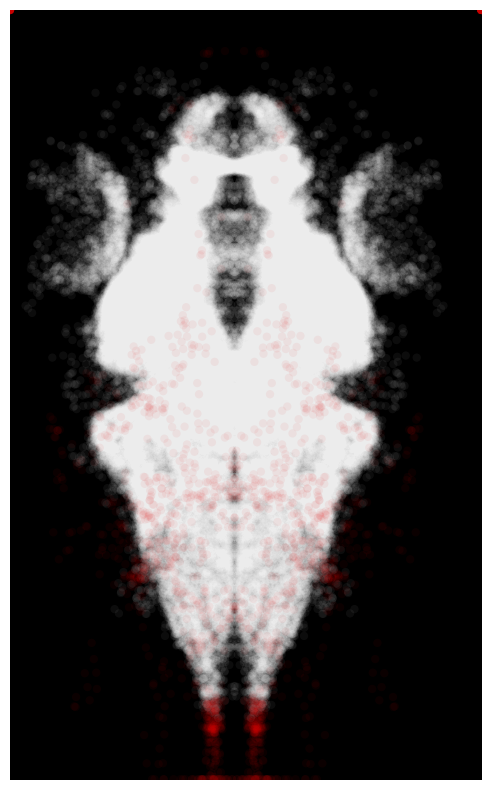

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
#ax.imshow(atlas.XZprojection, cmap='gray')
ax.imshow(np.zeros(atlas.XYprojection.shape), cmap='gray')
plt.scatter(T_in[:, 0], T_in[:, 1], alpha=0.05, color=[1, 1, 1], edgecolor='None')
plt.scatter(T_out[:, 0], T_out[:, 1], alpha=0.05, color=[0.9, 0, 0], edgecolor='None')

plt.axis('off')
plt.xlim([0, atlas.XYprojection.shape[1]])
plt.ylim([atlas.XYprojection.shape[0], 0])

(359.0, 0.0)

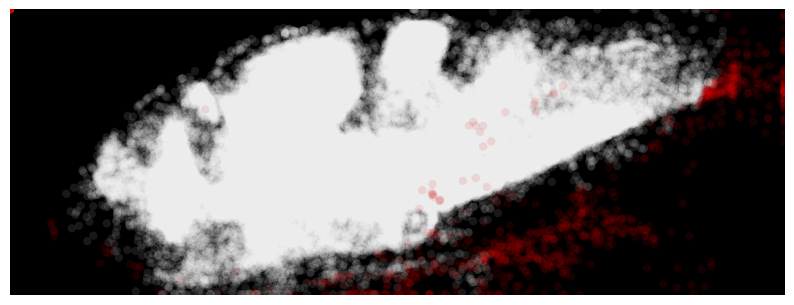

In [32]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(atlas.XZprojection, cmap='gray')
ax.imshow(np.zeros(atlas.XZprojection.shape), cmap='gray')
plt.scatter(T_in[:, 1], T_in[:, 2], alpha=0.05, color=[1, 1, 1], edgecolor='None')
plt.scatter(T_out[:, 1], T_out[:, 2], alpha=0.05, color=[0.9, 0, 0], edgecolor='None')

plt.axis('off')
plt.xlim([0, atlas.XZprojection.shape[1]])
plt.ylim([atlas.XZprojection.shape[0], 0])

In red, we can see terminals that "fall into the cracks" of the brain region ROIs. As we increase the region boundary sizes, the fraction of such terminals diminishes rapidly:

In [33]:
for i in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    regions_terminals = np.load('Results/regions_terminals_expanded_{}.npy'.format(i))
    fraction_in = np.sum(np.sum(regions_terminals, axis=1) == 0) / regions_terminals.shape[0]
    print(fraction_in)

0.032080170267033165
0.01685436826277649
0.012545991917485975
0.010589989056724083
0.00913375785201589
0.008030813507621517
0.0071174377224199285
0.00645394776524519
0.005747374044617545
0.004971866302465253


Without any expansion:

In [35]:
regions_terminals = np.load('Results/regions_terminals.npy'.format(i))

In [36]:
fraction_in = np.sum(np.sum(regions_terminals, axis=1) == 0) / regions_terminals.shape[0]
print(fraction_in)

0.09554255383316243


About 10% of terminals are not used for connectivity counts in raw brain region ROIs.

# Computing connectivity matrices from mapped neural elements

In [37]:
def compute_directed(matrix):
    adjacency = np.copy(matrix)
    for i in range(adjacency.shape[0]):
        for j in range(i + 1, adjacency.shape[0]):
            adjacency[i, j] = adjacency[i, j] / (atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
            adjacency[j, i] = adjacency[j, i] / (atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
    adjacency[adjacency > 0] = np.log10(adjacency[adjacency > 0])
    adjacency[np.diag_indices(adjacency.shape[0])] = 0
    return normalize(adjacency)

def compute_undirected(matrix):
    adjacency = np.copy(matrix)
    for i in range(adjacency.shape[0]):
        for j in range(i + 1, adjacency.shape[0]):
            adjacency[i, j] = (adjacency[i, j] + adjacency[j, i]) / (
                        atlas.relativeVolumes[i] + atlas.relativeVolumes[j])
            adjacency[j, i] = adjacency[i, j]
    adjacency[adjacency > 0] = np.log10(adjacency[adjacency > 0])
    adjacency[np.diag_indices(adjacency.shape[0])] = 0
    return normalize(adjacency)

from scipy.stats import norm, kstest

def evaluate_weights_lognormality(matrix, plot=True):
    data = matrix[matrix != 0]
    mean = np.mean(data)
    std = np.std(data)
    fitted_pdf = norm.pdf(np.sort(data), mean, std)
    _, p_value = kstest(data, 'norm', args=(mean, std))

    if plot:
        fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
        plt.hist(data, bins=50, density=True, color='black', alpha=0.5)
        plt.plot(np.sort(data), fitted_pdf, color='r')
        ax.spines[['top', 'right']].set_visible(False)
        ax.set_xlabel('Connection weight')
        ax.set_ylabel('Probability density')
        plt.show()
        
    return p_value

Loading mapped neuron coordinates

In [38]:
regions_somas = np.load('Results/regions_somas.npy')
regions_terminals = np.load('Results/regions_terminals.npy')
regions_coords = np.load('Results/regions_coords.npy')
regions_terminals_periphery = np.load('Results/regions_terminals_expanded_30.npy')

FC = np.load('Results/FC_matrix.npy')
tri = np.triu_indices(65, 1)

### Method 1: Total wiring length (not restricted to terminals)

In [39]:
N_neurons = somas.shape[0]

In [40]:
connectivity_wiring = np.zeros((70, 70))

for i in tqdm(range(N_neurons), file=sys.stdout):
    c = coords[ids_coords == i]
    p = parents[ids_coords == i]
    p[p > 0] = p[p > 0] - 1
    regions = regions_coords[ids_coords == i]
    for region_j in np.where(regions_somas[i])[0]: # Slim chance that soma is located in a rare overlapping spot between regions 
        for region_i in np.where(np.sum(regions, axis=0) > 0)[0]:
            if region_i != region_j:
                in_region = regions[:, region_i] > 0
                coords_in = c[in_region]
                parents_in = p[in_region]
                total_length = []
                for j, point in enumerate(coords_in):
                    parent = parents_in[j]
                    try:
                        if in_region[parent]:
                            point1 = point
                            point2 = c[parent]
                            dist = np.sqrt(np.sum((point2 - point1) ** 2))
                            total_length.append(dist)
                    except:
                        pass
                connectivity_wiring[region_i, region_j] += np.sum(total_length)

100%|██████████████████████████████████████| 4327/4327 [00:33<00:00, 127.37it/s]


Raw connectivity

(0.0, 1.0, 0.0, 1.0)

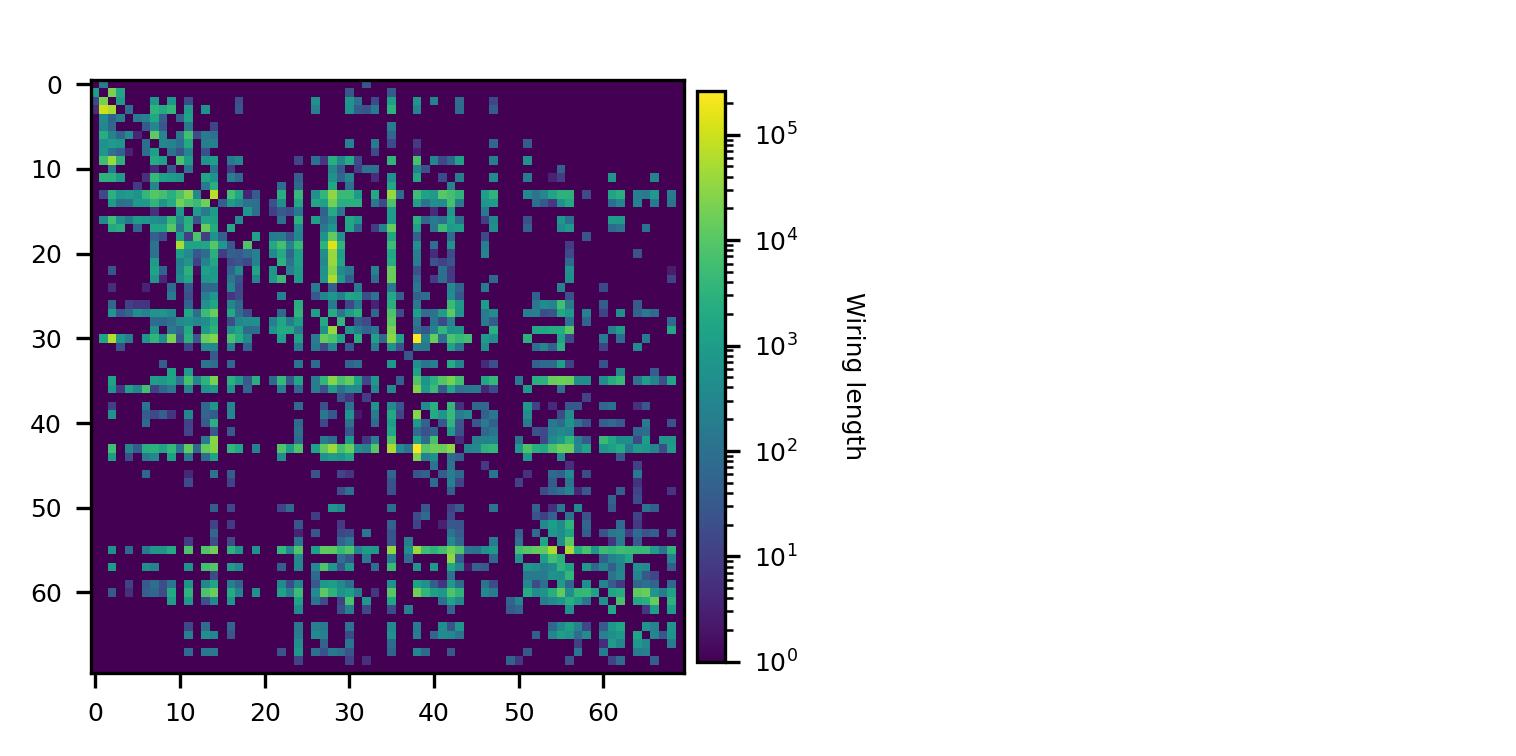

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
cax = ax[0].imshow(connectivity_wiring + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Wiring length', rotation=270, labelpad=16)

ax[1].axis('off')

Normalized connectivity

In [42]:
dir_wiring = compute_directed(connectivity_wiring)
und_wiring = compute_undirected(connectivity_wiring)

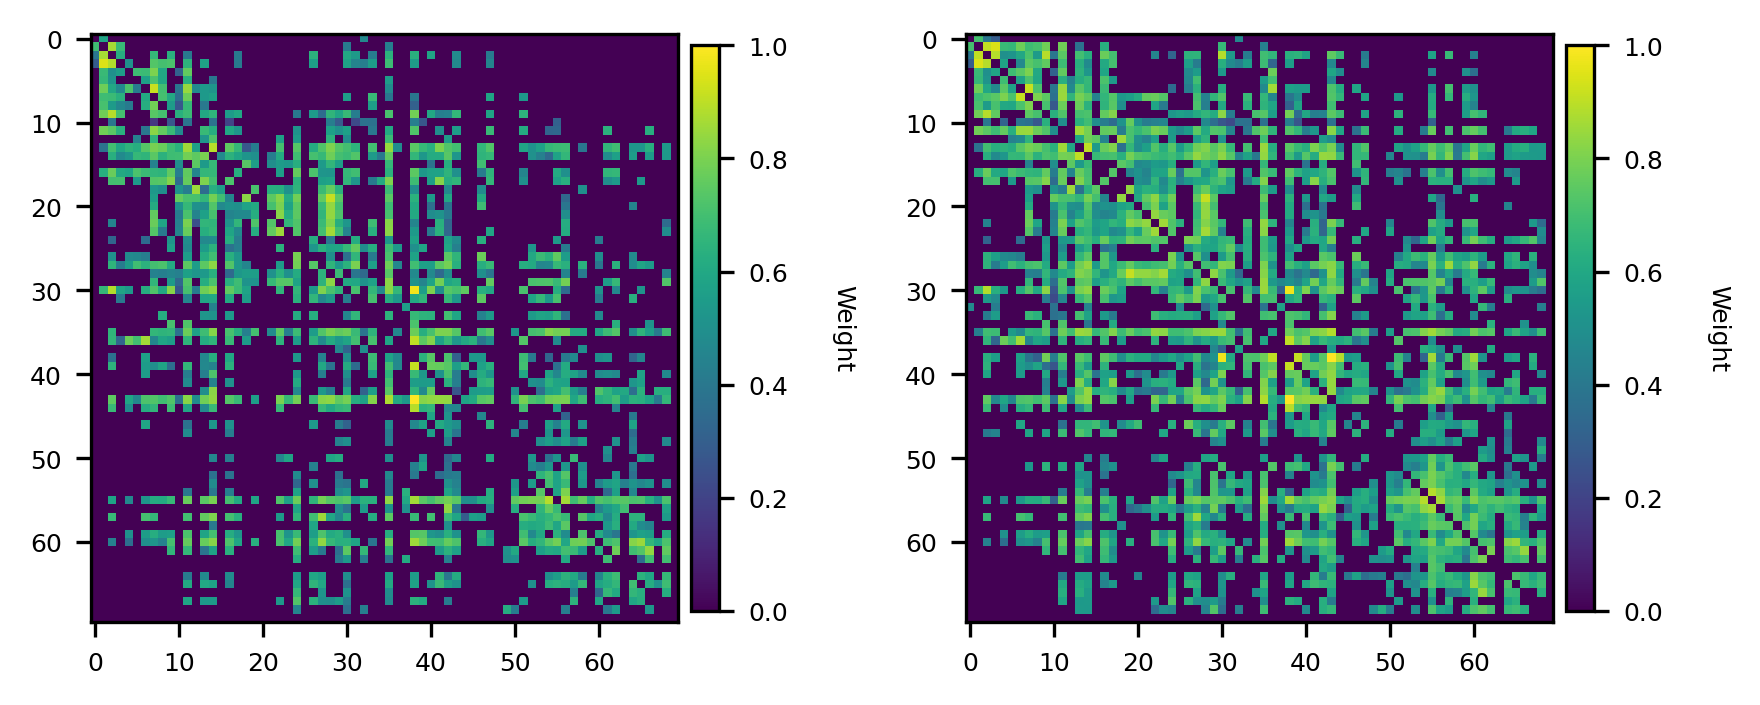

In [43]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)

cax = ax[0].imshow(dir_wiring)
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Weight', rotation=270, labelpad=16)

cax = ax[1].imshow(und_wiring)
cbar = plt.colorbar(cax, ax=ax[1], fraction=0.045, pad=0.02)
cbar.set_label('Weight', rotation=270, labelpad=16)

plt.tight_layout(pad=2)

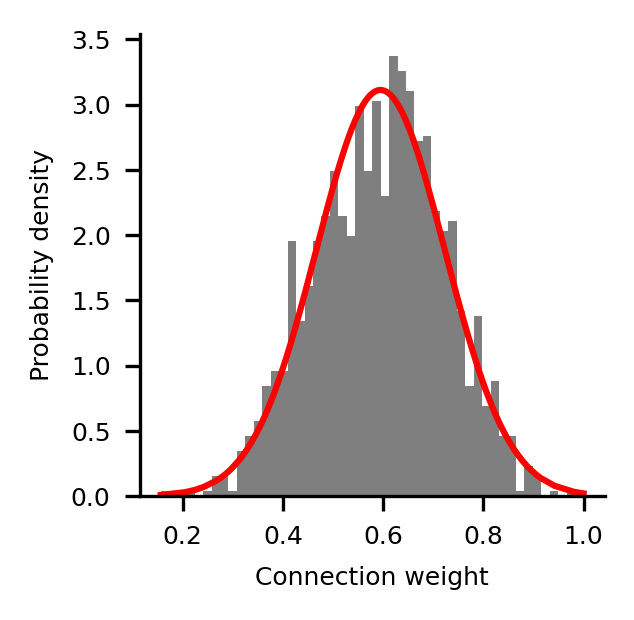

Probability of being log-normally distributed:
0.07956984228124009


In [44]:
p_value = evaluate_weights_lognormality(dir_wiring)
print('Probability of being log-normally distributed:')
print(p_value)

In [45]:
print('Baseline structure-function correlation:')
print(pearsonr(FC[tri], delete_rows_and_columns(und_wiring, excluded)[tri])[0])

Baseline structure-function correlation:
0.47639122429426256


### Method 2: Total wiring length (restricted to terminals)

In [27]:
N_neurons = somas.shape[0]

In [28]:
connectivity_wiring_terminals = np.zeros((70, 70))

for i in tqdm(range(N_neurons), file=sys.stdout):
    c = coords[ids_coords == i]
    p = parents[ids_coords == i]
    p[p > 0] = p[p > 0] - 1
    regions = regions_coords[ids_coords == i]
    regions_t = regions_terminals[ids_terminals == i]
    for region_j in np.where(regions_somas[i])[0]: # Slim chance that soma is located in a rare overlapping spot between regions 
        for region_i in np.where(np.sum(regions, axis=0) > 0)[0]:
            if np.any(regions_t[:, region_i]):
                if region_i != region_j:
                    in_region = regions[:, region_i] > 0
                    coords_in = c[in_region]
                    parents_in = p[in_region]
                    total_length = []
                    for j, point in enumerate(coords_in):
                        parent = parents_in[j]
                        try:
                            if in_region[parent]:
                                point1 = point
                                point2 = c[parent]
                                dist = np.sqrt(np.sum((point2 - point1) ** 2))
                                total_length.append(dist)
                        except:
                            pass
                    connectivity_wiring_terminals[region_i, region_j] += np.sum(total_length)

100%|██████████████████████████████████████| 4327/4327 [00:32<00:00, 135.20it/s]


Raw connectivity

(0.0, 1.0, 0.0, 1.0)

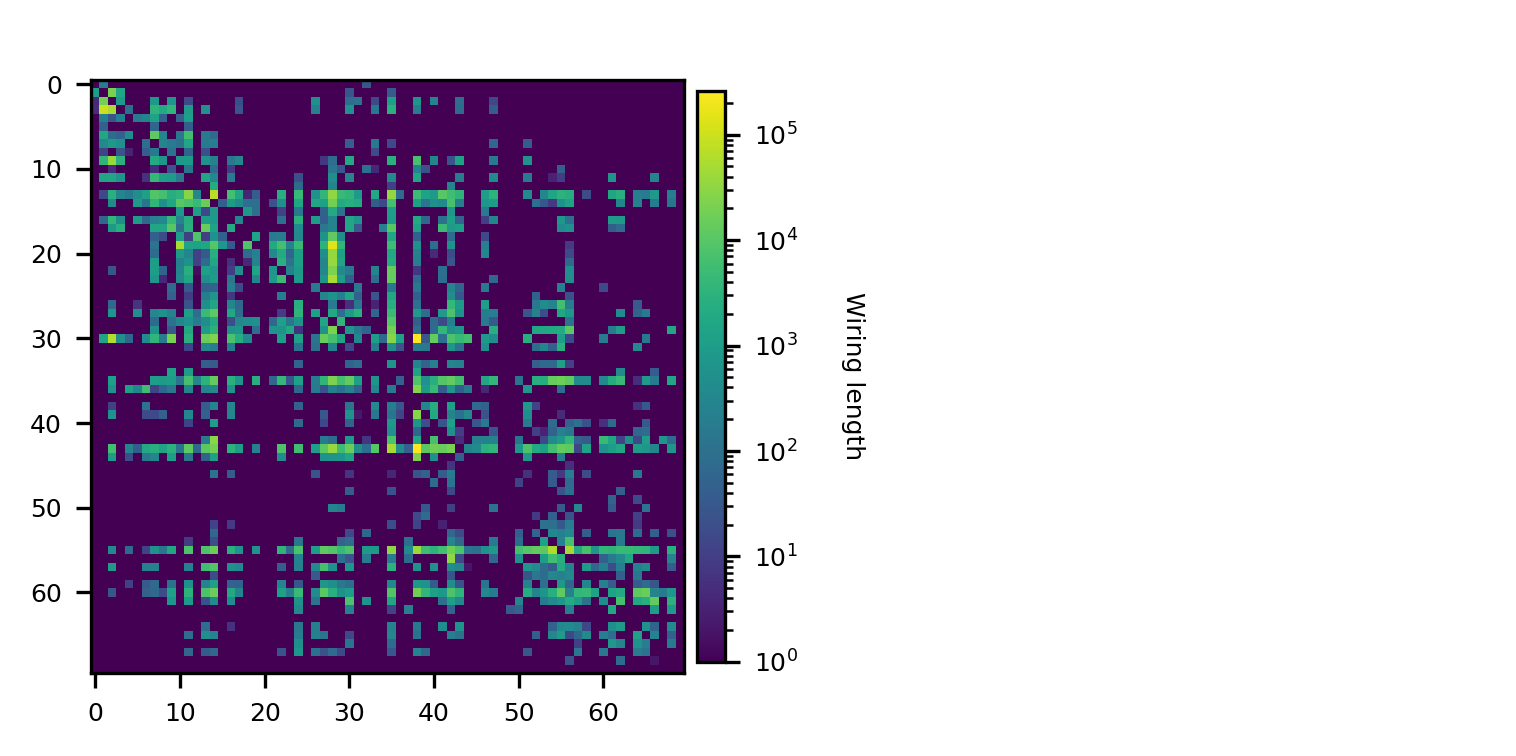

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
cax = ax[0].imshow(connectivity_wiring_terminals + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Wiring length', rotation=270, labelpad=16)

ax[1].axis('off')

Normalized connectivity

In [30]:
dir_wiring_terminals = compute_directed(connectivity_wiring_terminals)
und_wiring_terminals = compute_undirected(connectivity_wiring_terminals)

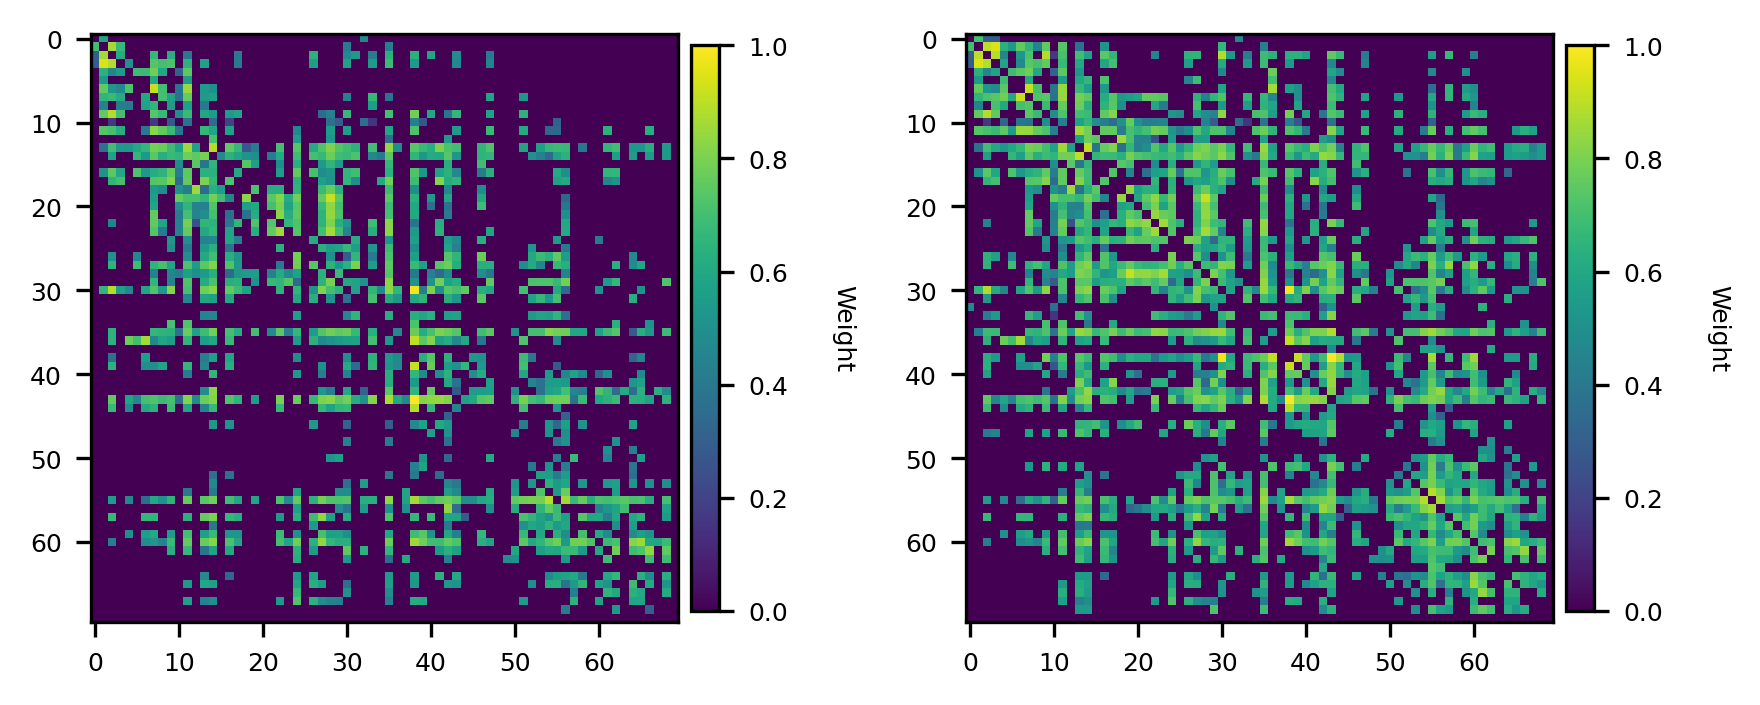

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)

cax = ax[0].imshow(dir_wiring_terminals)
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Weight', rotation=270, labelpad=16)

cax = ax[1].imshow(und_wiring_terminals)
cbar = plt.colorbar(cax, ax=ax[1], fraction=0.045, pad=0.02)
cbar.set_label('Weight', rotation=270, labelpad=16)

plt.tight_layout(pad=2)

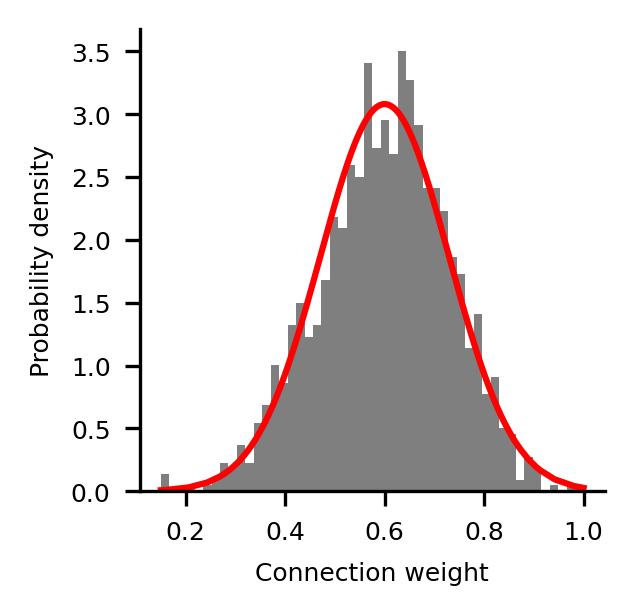

Probability of being log-normally distributed:
0.2526032563179419


In [32]:
p_value = evaluate_weights_lognormality(dir_wiring_terminals)
print('Probability of being log-normally distributed:')
print(p_value)

In [33]:
print('Baseline structure-function correlation:')
pearsonr(FC[tri], delete_rows_and_columns(und_wiring_terminals, excluded)[tri])[0]

Baseline structure-function correlation:


0.4687256773351597

### Method 3: Terminal count (Normal region size)

Connection counts are given when a neuron whose soma is located in region $j$ has a terminal in target region $i$. A single neuron can contribute multiple counts by having multiple terminals in a single target region. Counts are summed across all neurons.

In [42]:
from matplotlib.colors import LogNorm

In [43]:
connectivity = np.zeros((70, 70))
for i in range(terminals.shape[0]):
    if (np.sum(regions_somas[ids_terminals[i], :]) > 0) and (np.sum(regions_terminals[i, :]) > 0):
        r1 = np.where(regions_somas[ids_terminals[i]])[0][0]
        r2 = np.where(regions_terminals[i])[0][0]
        connectivity[r2, r1] += 1

Raw connectivity

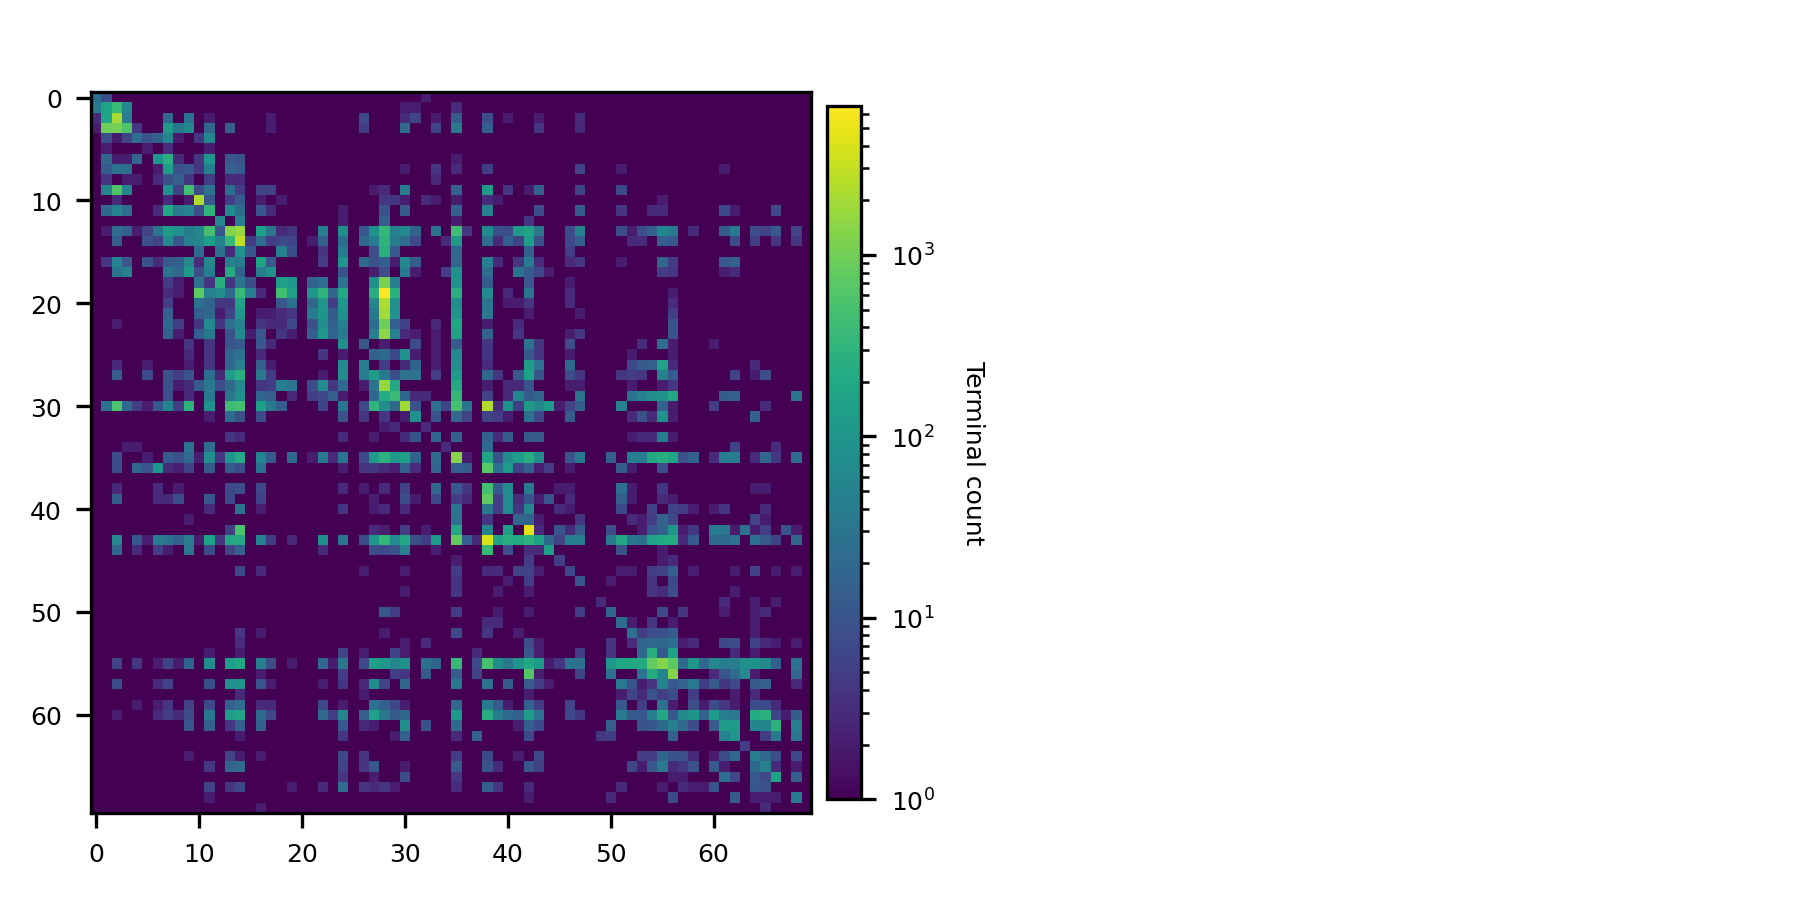

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
cax = ax[0].imshow(connectivity + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Terminal count', rotation=270, labelpad=12)

ax[1].axis('off')

plt.tight_layout(pad=1)

In [56]:
np.save('Results/raw_connectivity_terminals.npy', connectivity)

Normalized weights

In [45]:
und = compute_undirected(connectivity)
und_expanded = compute_undirected(connectivity_expanded)

dir = compute_directed(connectivity)
dir_expanded = compute_directed(connectivity_expanded)

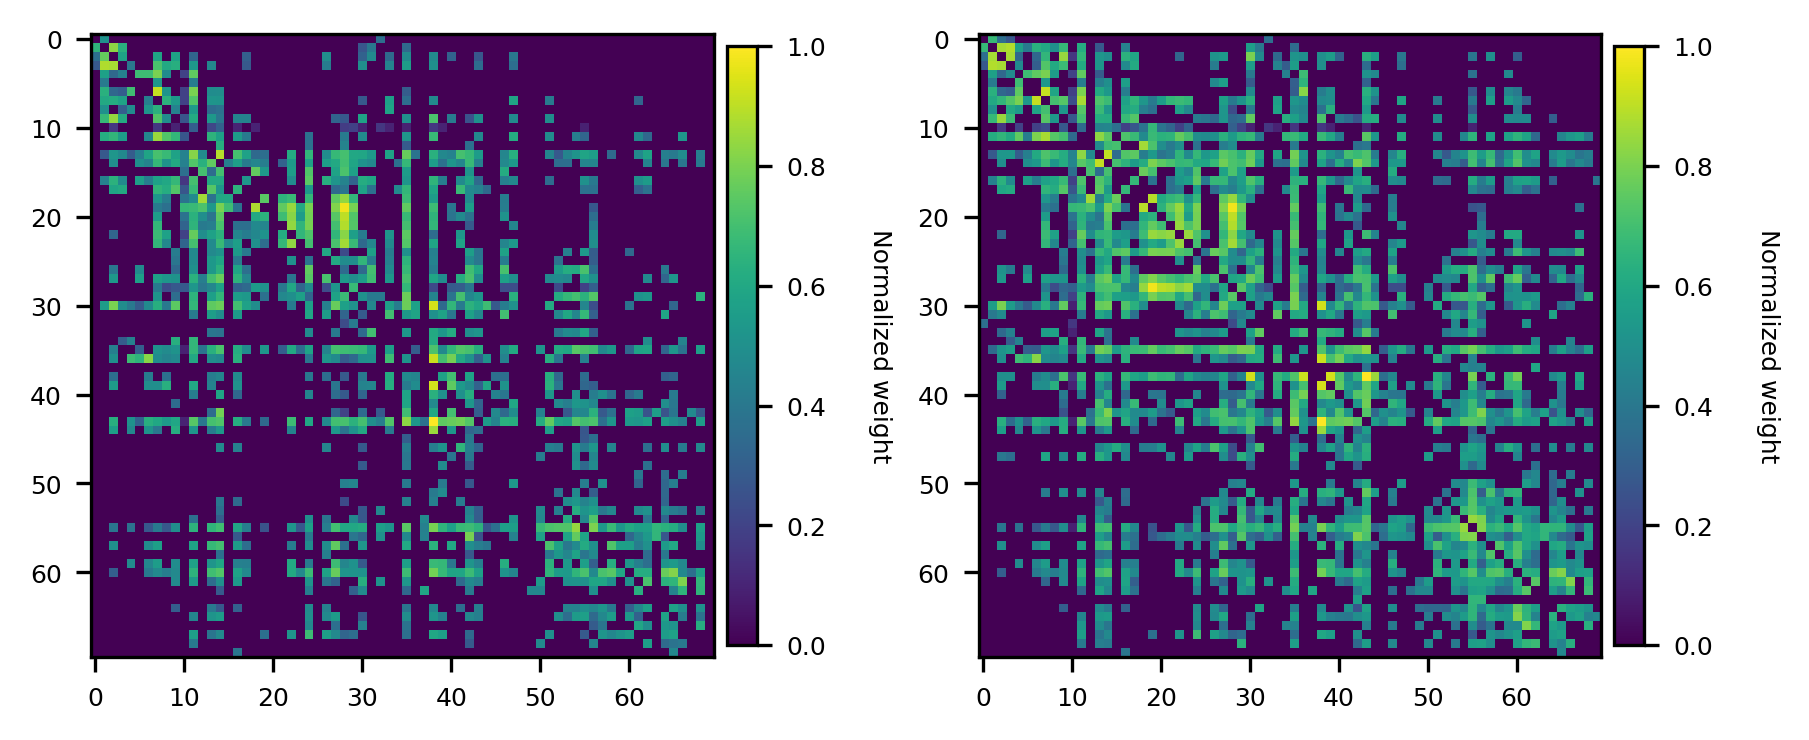

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
cax = ax[0].imshow(dir)
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Normalized weight', rotation=270, labelpad=16)

cax = ax[1].imshow(und)
cbar = plt.colorbar(cax, ax=ax[1], fraction=0.045, pad=0.02)
cbar.set_label('Normalized weight', rotation=270, labelpad=16)

plt.tight_layout(pad=1)

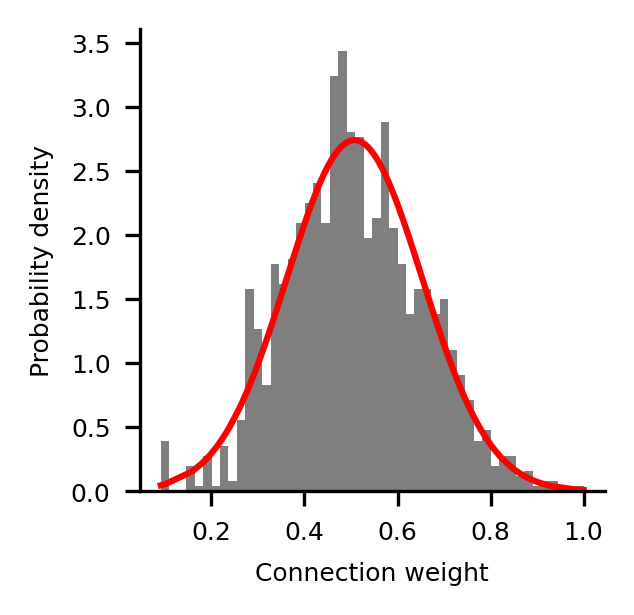

Probability of being log-normally distributed:
0.2233332957931915


In [47]:
p_value = evaluate_weights_lognormality(dir)
print('Probability of being log-normally distributed:')
print(p_value)

In [48]:
print('Baseline structure-function correlation:')
pearsonr(delete(und, excluded)[tri], FC[tri])[0]

Baseline structure-function correlation:


0.48738177054601173

### Method 4: Terminal count (Expanded region size)

Connection counts are given when a neuron whose soma is located in region $j$ has a terminal in target region $i$. A single neuron can contribute multiple counts by having multiple terminals in a single target region. Counts are summed across all neurons.

In [49]:
from matplotlib.colors import LogNorm

In [50]:
connectivity_expanded = np.zeros((70, 70))
for i in range(terminals.shape[0]):
    if (np.sum(regions_somas[ids_terminals[i], :]) > 0) and (np.sum(regions_terminals_periphery[i, :]) > 0):
        r1 = np.where(regions_somas[ids_terminals[i]])[0][0]
        for j in range(regions_terminals_periphery.shape[1]):
            if regions_terminals_periphery[i, j] > 0:
                r2 = j
                connectivity_expanded[r2, r1] += 1

In [58]:
np.save('Results/raw_connectivity_terminals_expanded.npy', connectivity_expanded)

Raw connectivity

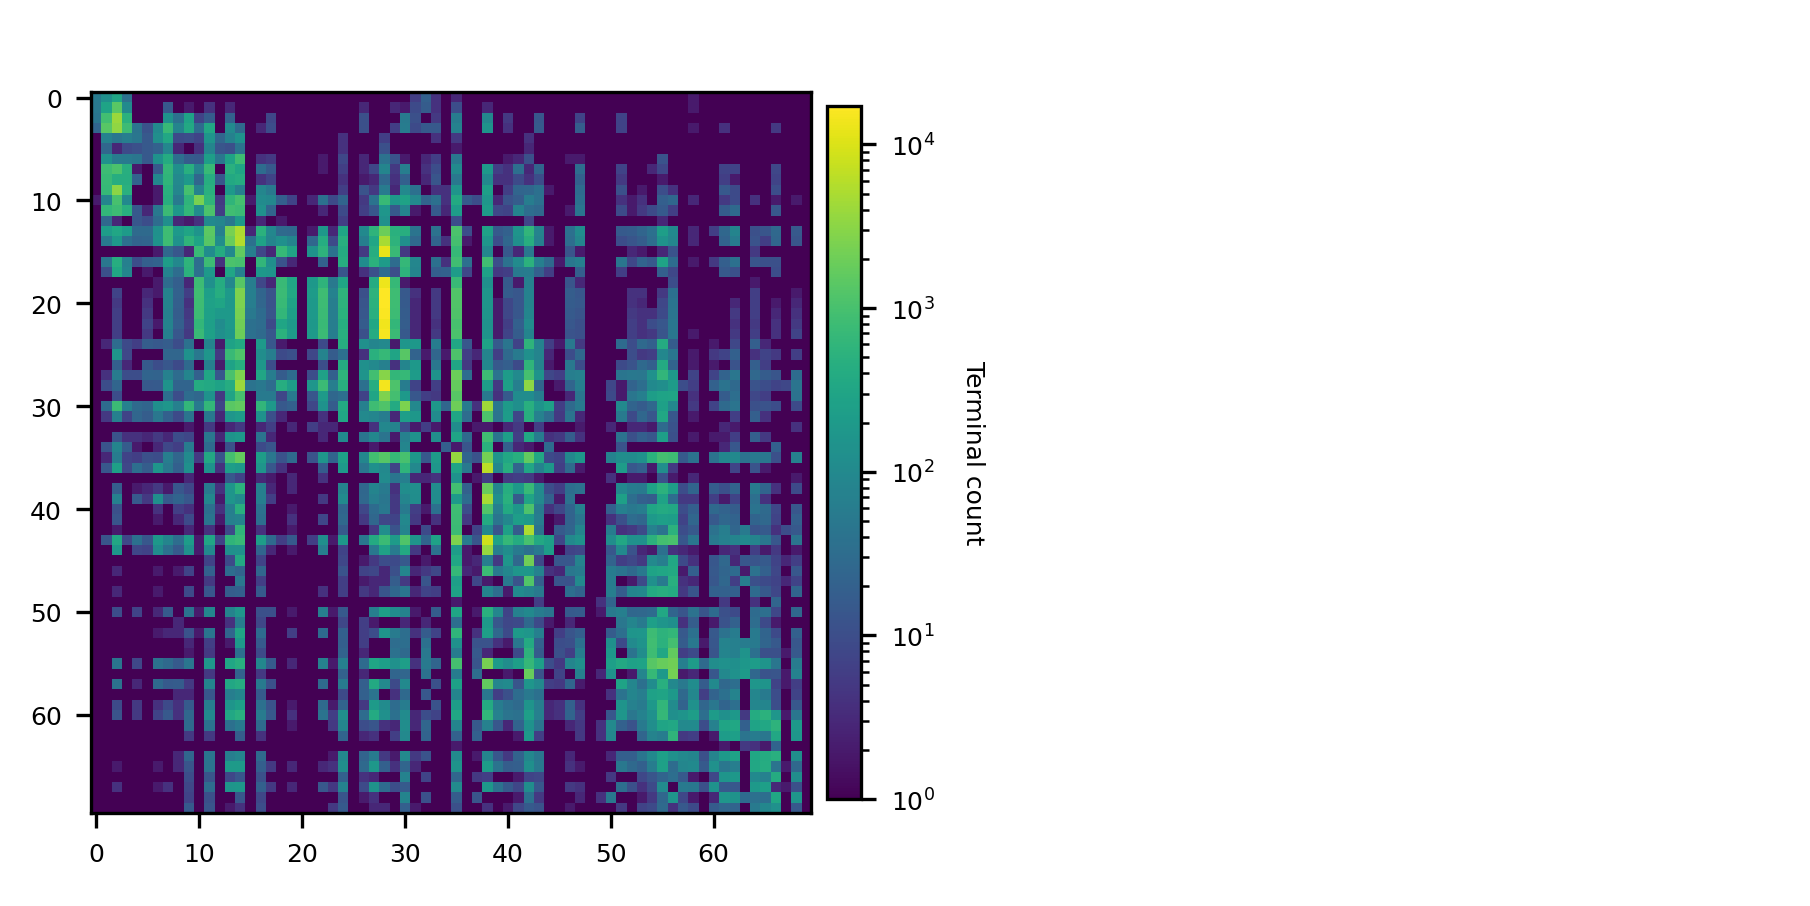

In [51]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
cax = ax[0].imshow(connectivity_expanded + 1, norm=LogNorm())
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Terminal count', rotation=270, labelpad=12)

ax[1].axis('off')

plt.tight_layout(pad=1)

Normalized weights

In [52]:
und_expanded = compute_undirected(connectivity_expanded)
dir_expanded = compute_directed(connectivity_expanded)

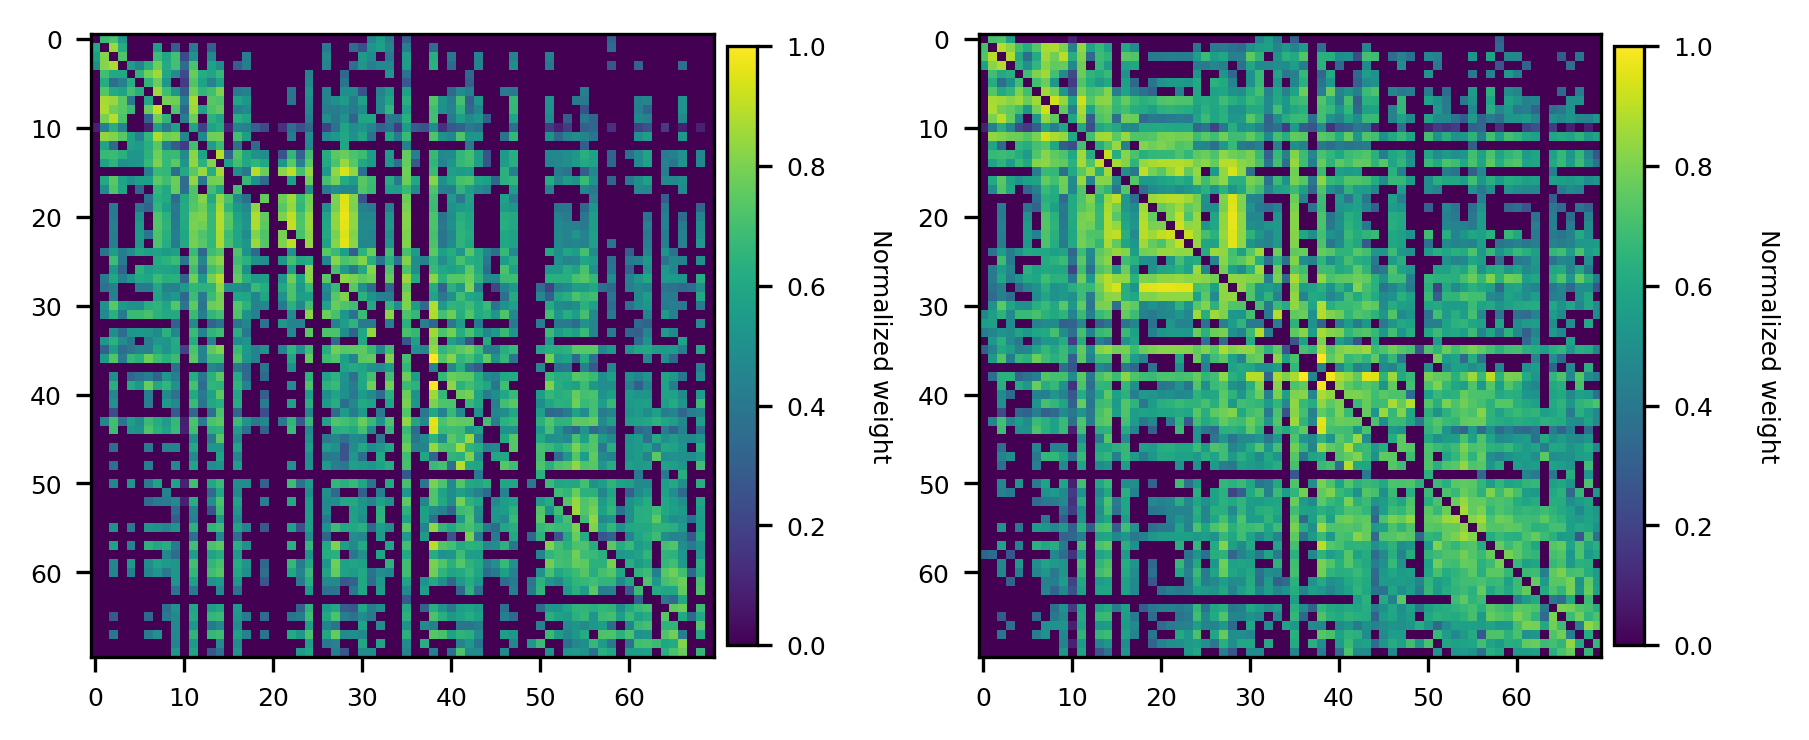

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3), dpi=300)
cax = ax[0].imshow(dir_expanded)
cbar = plt.colorbar(cax, ax=ax[0], fraction=0.045, pad=0.02)
cbar.set_label('Normalized weight', rotation=270, labelpad=16)

cax = ax[1].imshow(und_expanded)
cbar = plt.colorbar(cax, ax=ax[1], fraction=0.045, pad=0.02)
cbar.set_label('Normalized weight', rotation=270, labelpad=16)

plt.tight_layout(pad=1)

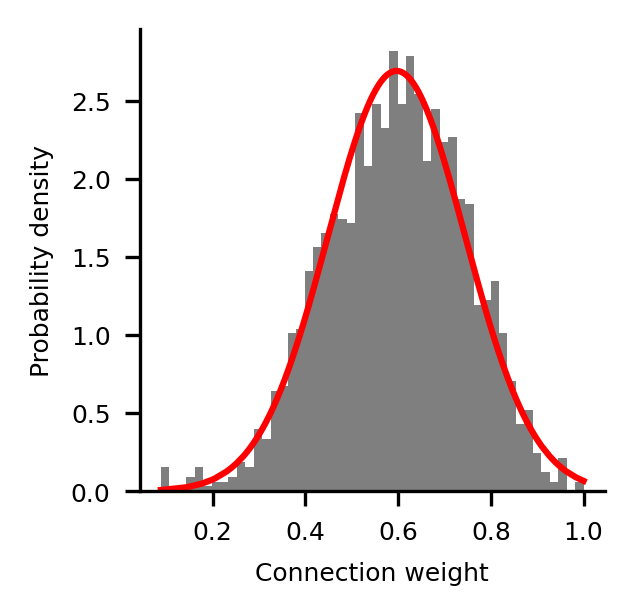

Probability of being log-normally distributed:
0.05709893268402333


In [54]:
p_value = evaluate_weights_lognormality(und_expanded)
print('Probability of being log-normally distributed:')
print(p_value)

In [55]:
print('Baseline structure-function correlation:')
pearsonr(delete(und_expanded, excluded)[tri], FC[tri])[0]

Baseline structure-function correlation:


0.5678666489568499

# Saving connectivity matrices

Only saving matrices generated from terminal counts as they correlate more with FC.

In [54]:
np.save('Data/directed_terminals.npy', dir)
np.save('Data/undirected_terminals.npy', und)
np.save('Data/directed_terminals_expanded.npy', dir_expanded)
np.save('Data/undirected_terminals_expanded.npy', und_expanded)

# Supplementary Figures

In [55]:
color1 = [0, 0, 0]
color3 = [1, 1, 1]
blue = hex2rgb('#006DAA')
cmap = make_cmap([color1, blue, color3], [0, 0.5, 1])

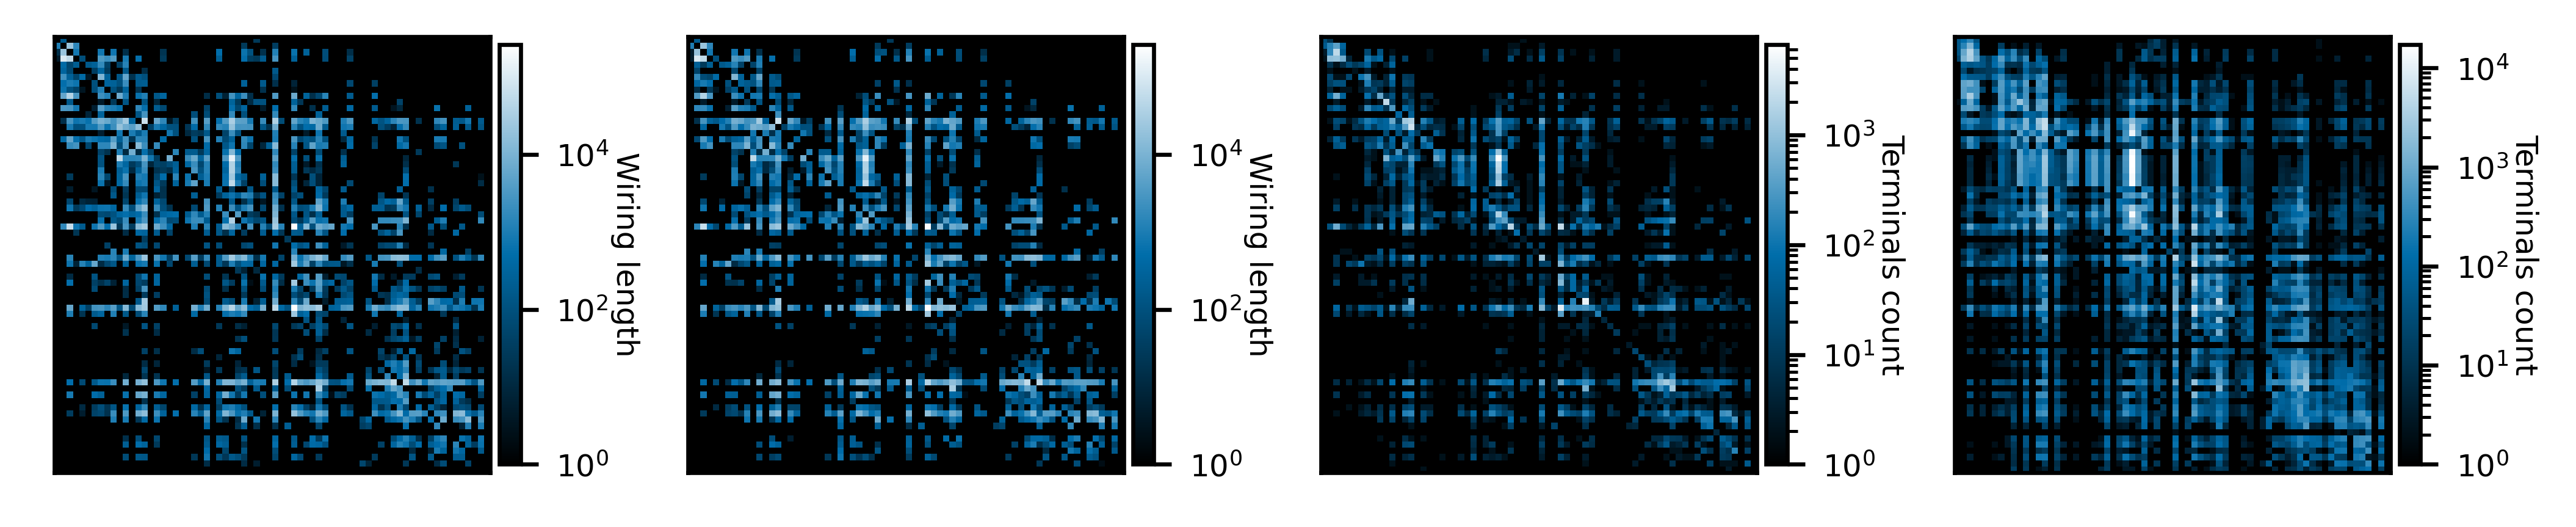

In [56]:
fig, axes = plt.subplots(1, 4, figsize=(7, 7/4), dpi=600)

labelpad = 6
cmap = cmap

ax = axes[0]
cax = ax.imshow(connectivity_wiring + 1, norm=LogNorm(), cmap=cmap)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
cbar.set_label('Wiring length', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
cax = ax.imshow(connectivity_wiring_terminals + 1, norm=LogNorm(), cmap=cmap)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
cbar.set_label('Wiring length', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[2]
cax = ax.imshow(connectivity + 1, norm=LogNorm(), cmap=cmap)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
cbar.set_label('Terminals count', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[3]
cax = ax.imshow(connectivity_expanded + 1, norm=LogNorm(), cmap=cmap)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
cbar.set_label('Terminals count', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout(pad=1)

plt.savefig('/home/anleg84/Documents/Figures/PaperNetworks2024/figuresupp_wiring_directed.svg')

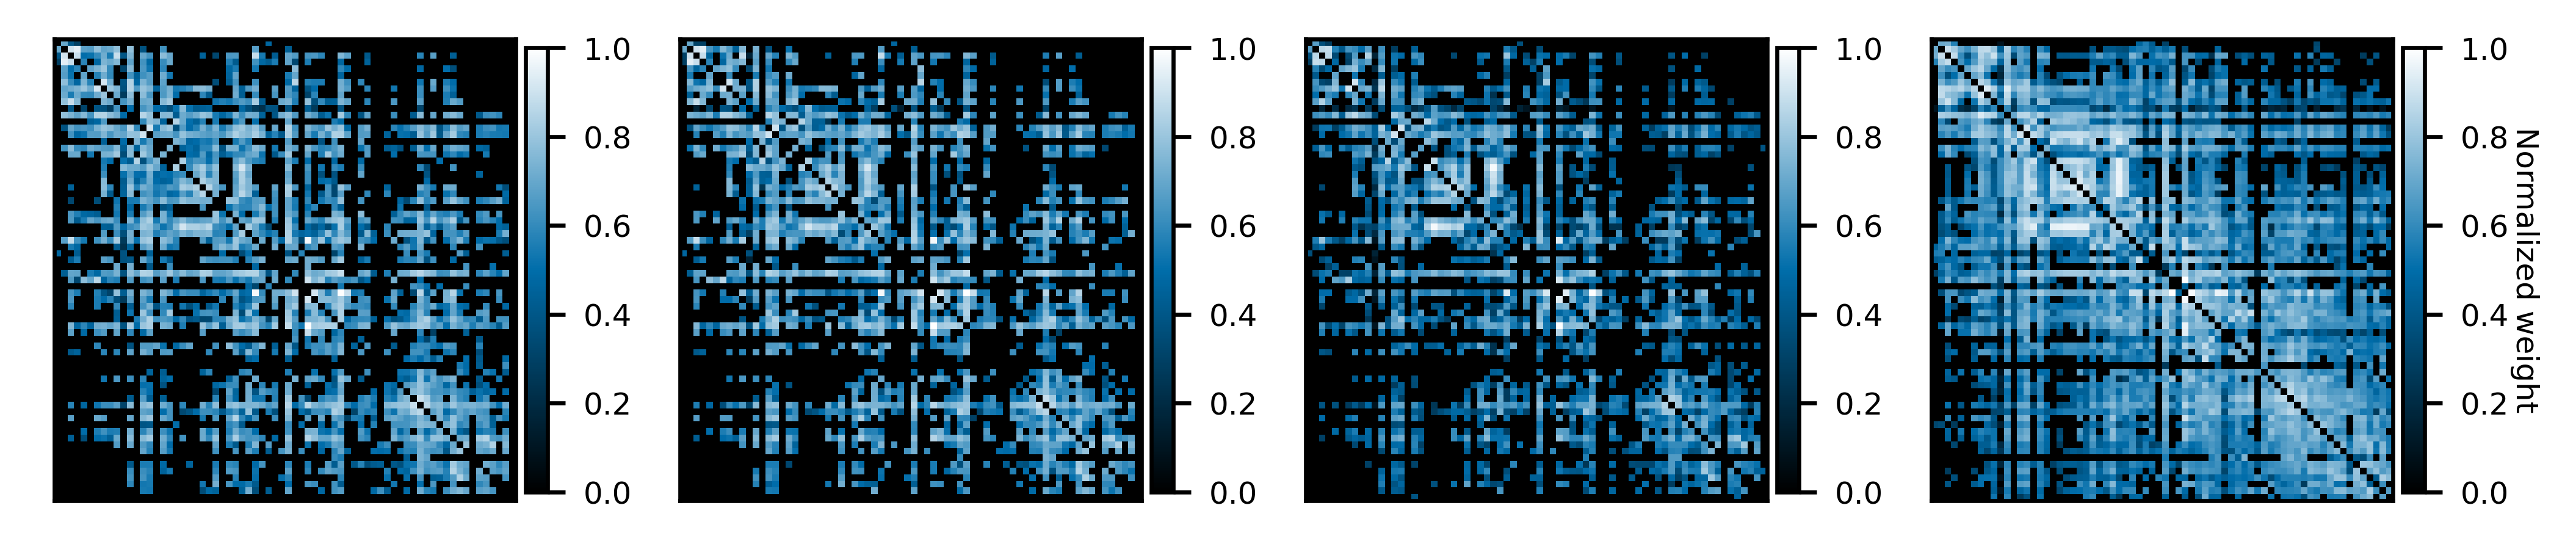

In [57]:
fig, axes = plt.subplots(1, 4, figsize=(7, 7/4), dpi=600)

labelpad = 6
cmap = cmap

ax = axes[0]
cax = ax.imshow(und_wiring, cmap=cmap)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
#cbar.set_label('Wiring length', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
cax = ax.imshow(und_wiring_terminals, cmap=cmap)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
#cbar.set_label('Wiring length', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[2]
cax = ax.imshow(und, cmap=cmap)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
#cbar.set_label('Terminals count', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[3]
cax = ax.imshow(und_expanded, cmap=cmap)
cbar = plt.colorbar(cax, ax=ax, fraction=0.045, pad=0.02)
cbar.set_label('Normalized weight', rotation=270, labelpad=labelpad)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout(pad=1)

plt.savefig('/home/anleg84/Documents/Figures/PaperNetworks2024/figuresupp_wiring_undirected.svg')

In [58]:
def plot_weights_lognormality(ax, matrix):
    data = matrix[matrix != 0]
    mean = np.mean(data)
    std = np.std(data)
    fitted_pdf = norm.pdf(np.sort(data), mean, std)
    _, p_value = kstest(data, 'norm', args=(mean, std))

    ax.hist(data, bins=50, density=True, color='black', alpha=0.5)
    ax.plot(np.sort(data), fitted_pdf, color=red)
    ax.spines[['top', 'right']].set_visible(False)
    ax.set_xlabel('Connection weight')
    ax.set_ylabel('Probability density')

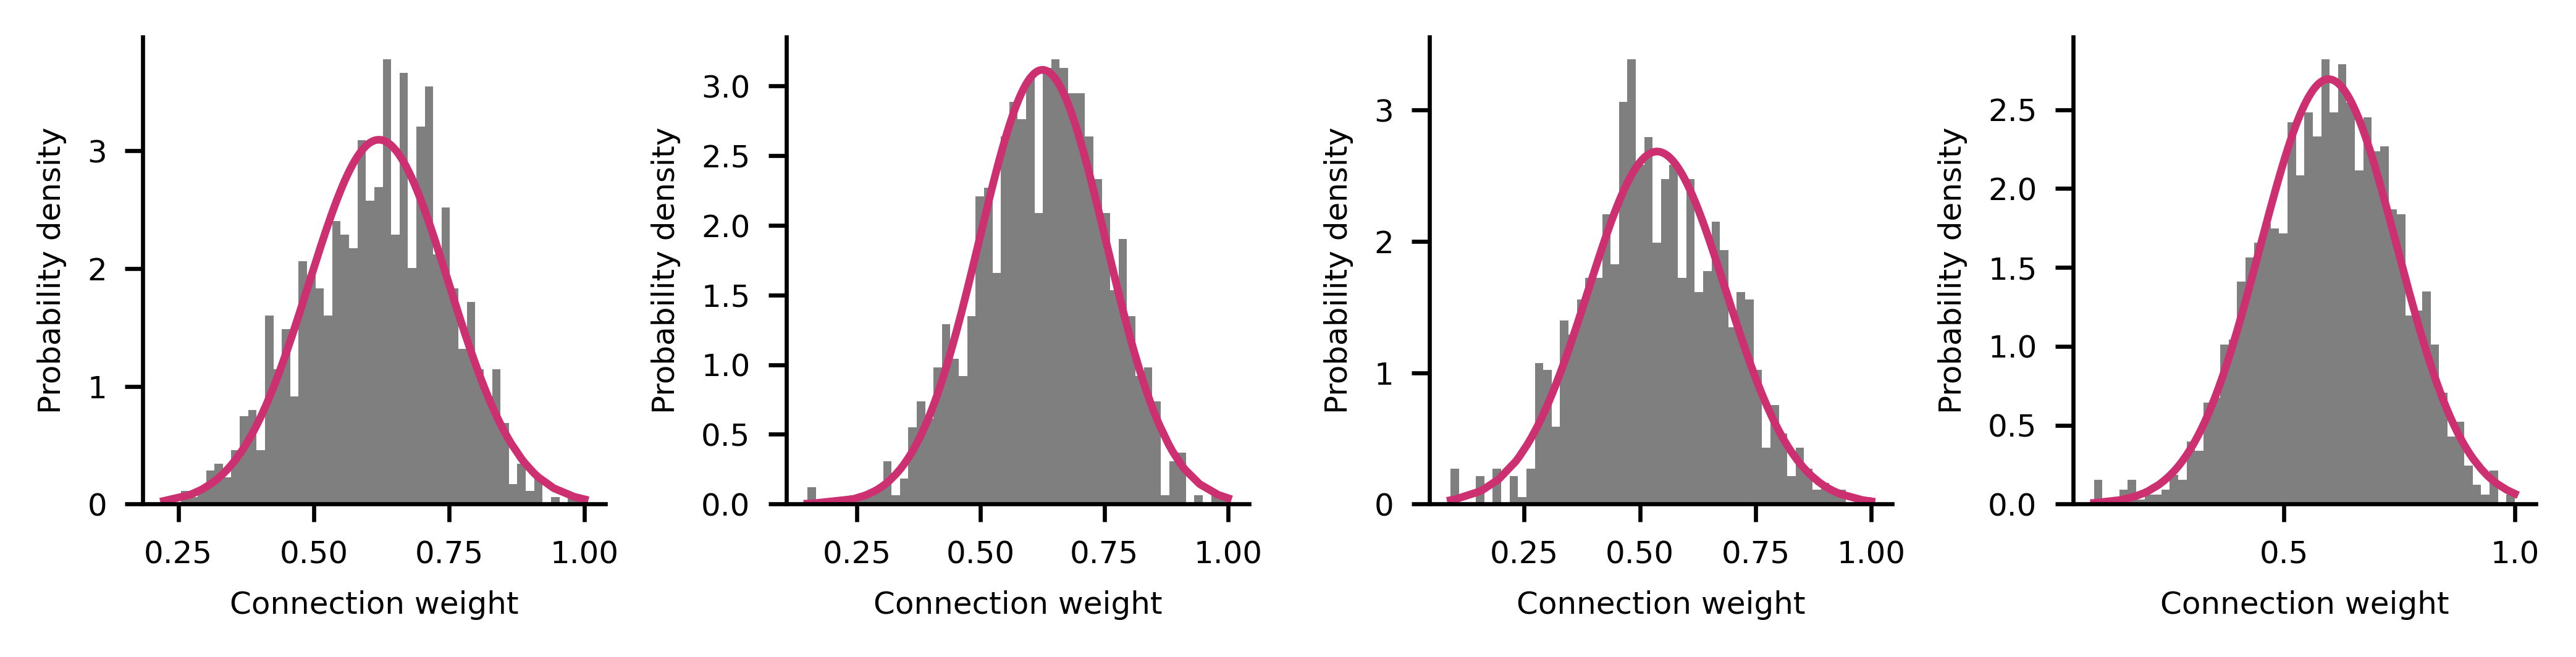

In [59]:
fig, axes = plt.subplots(1, 4, figsize=(7, 7/4), dpi=600)

labelpad = 6
cmap = cmap

ax = axes[0]
plot_weights_lognormality(ax, und_wiring)

ax = axes[1]
plot_weights_lognormality(ax, und_wiring_terminals)

ax = axes[2]
plot_weights_lognormality(ax, und)

ax = axes[3]
plot_weights_lognormality(ax, und_expanded)

plt.tight_layout(pad=1)

plt.savefig('/home/anleg84/Documents/Figures/PaperNetworks2024/figuresupp_wiring_distributions.svg')